# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
#env = UnityEnvironment(file_name='C:\\Users\\kvjos\\udacityRL\\deep-reinforcement-learning\\p2_continuous-control\\Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='Reacher.app')

UnityEnvironmentException: Couldn't launch the Reacher environment. Provided filename does not match any environments.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for i in range(1000):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.13799999691545964


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 4.1 Create the actor-critic network

The actor-critic PPO consists of two neural networks - one that is responsible for creating the policy, and the other that estimates the value of a given state.

In [5]:
# First create the neural network powering our agent
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
     
        self.size = 33
        self.fc1 = nn.Linear(self.size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
        self.critic_fc1 = nn.Linear(self.size,512)
        self.critic_fc2 = nn.Linear(512,256)
        self.critic_fc3 = nn.Linear(256,1)
        self.normalDistParams = torch.ones((1,4),device=device)
        self.to(device)
        
    def forward(self, x,sampled_actions=None):
        a  = torch.tensor(x,dtype=torch.float,device=device)
        a = F.relu(self.fc1(a))
        a = F.relu(self.fc2(a))
        a = F.tanh(self.fc3(a))
        
        v = torch.tensor(x,dtype=torch.float,device=device)
        v = F.relu(self.critic_fc1(v))
        v = F.relu(self.critic_fc2(v))
        v = self.critic_fc3(v)
        
       
        #x is now the mean of a normal distribution from which we
        #sample the actual action values
        prob_dists = torch.distributions.Normal(a,self.normalDistParams)
        if sampled_actions is None:
            sampled_actions = prob_dists.sample()
        action_probabilities = prob_dists.log_prob(sampled_actions) #Prob of each individual action
        summed_action_probabilities = torch.sum(action_probabilities,dim=-1,keepdim=True)
        return sampled_actions,summed_action_probabilities,x,v
        


# run your own policy!
policy=Policy().to(device)

import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=3e-4)

#### 4.2 Generating trajectories

This function uses the current policy to generate a set of trajectories, and computes all the required information to train the policy

In [6]:
def generate_trajectories():
    rollout = []
    rollout_length = 600
    env_info = env.reset(train_mode=True)[brain_name]    
    states = env_info.vector_observations
    scores = np.zeros(num_agents)    
    
    for _ in range(rollout_length):
        #states_tensor = torch.Tensor(states,device=device).cuda()
        actions, log_probs, _, values = policy(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        terminals = np.array([1 if t else 0 for t in env_info.local_done])
        scores += env_info.rewards

        rollout.append([states, values.detach(), actions.detach(), log_probs.detach(), rewards, 1 - terminals])
        states = next_states

    pending_value = policy(states)[-1]
    rollout.append([states, pending_value, None, None, None, None])
    
    #Now that we have generated some trajectories
    processed_rollout = [None] * (len(rollout) - 1)
    advantages = torch.Tensor(np.zeros((20, 1))).to(device)
    returns = pending_value.detach()
    
    discount_rate = 0.99
    tau = 0.99
    for i in reversed(range(len(rollout) - 1)):
        states, value, actions, log_probs, rewards, terminals = rollout[i]
        terminals = torch.Tensor(terminals).unsqueeze(1).to(device)
        rewards = torch.Tensor(rewards).unsqueeze(1).to(device)
        actions = actions
        states = torch.Tensor(states).to(device)
        next_value = rollout[i + 1][1]
        returns = rewards + discount_rate * terminals * returns

        td_error = rewards + discount_rate * terminals * next_value.detach() - value.detach()
        advantages = advantages * tau * discount_rate * terminals + td_error
        processed_rollout[i] = [states, actions, log_probs, returns, advantages]
    
    processed_states,processed_actions,processed_log_probs,processed_returns,processed_adv = zip(*processed_rollout)
 
    #Convert into tensors
    processed_states = torch.cat(processed_states,dim=0)
    processed_actions = torch.cat(processed_actions,dim=0)
    processed_log_probs = torch.cat(processed_log_probs,dim=0)
    processed_returns = torch.cat(processed_returns,dim=0)
    processed_adv = torch.cat(processed_adv,dim=0)
    return processed_states,processed_actions,processed_log_probs,processed_returns,processed_adv,np.mean(scores)

#### 4.3 Optimizing step

The optimizing step consists of calculating a ratio of the probabilities of actions generated by the old network vs the new network. This ratio is then clipped so that it never diverges by a certain amount and multiplied by the estimated advantages. This then forms the policy loss. The value loss simply measures the difference between the estimated values of the critic network and the returns generated. 

Both losses are then fed through backpropagation to update the weights of the network

In [7]:
def optimize(sampled_states,sampled_actions,sampled_log_probs,sampled_returns,sampled_advantages):
    _, log_probs, entropy_loss, values = policy(sampled_states, sampled_actions)
    entropy_loss = torch.Tensor(np.zeros((log_probs.size(0), 1))).to(device)
    ratio = (log_probs - sampled_log_probs).exp()
    #print(ratio)
    obj = ratio * sampled_advantages
    obj_clipped = ratio.clamp(1.0 - 0.2,
                           1.0 + 0.2) * sampled_advantages
    #print(obj_clipped)
    policy_loss = -torch.min(obj, obj_clipped).mean(0) - 0.01 * entropy_loss.mean()
    #print(policy_loss)
    value_loss = 0.5 * (sampled_returns - values).pow(2).mean()
    #print(value_loss)

    optimizer.zero_grad()
    (policy_loss + value_loss).backward()
    #nn.utils.clip_grad_norm_(self.network.parameters(), hyperparameters['gradient_clip'])
    optimizer.step()

#### 4.4 Training
With the above infrastructure in place we can now train the network. At each step, we first generate some training data using the current version of the policy. That data is then split up into minibatches and used to optimize the network using gradient ascent.

At each episode we then run a simulation for 1000 steps and calculate the reward across all 20 agents. THis is the mean score for this step.

We also keep a running track of all mean scores, so that we can calculate the average score for the 100 most recent episodes. As per the project rubric, the problem is considered 'solved' once we have an average mean score of 30 over 100 episodes, so it will break out of the training loop once this is achieved or when we've gone through our maximum number of training iterations

In [8]:
num_training_steps = 1000
num_epochs_per_step = 5
all_mean_scores = []
for i in range(num_training_steps):
    step_states,step_actions,step_log_probs,step_rewards,step_advantages,mean_score = generate_trajectories()
    for j in range(num_epochs_per_step):
        shuffled_indices = np.arange(step_states.size(0))
        np.random.shuffle(shuffled_indices)
        
        minibatch_size = 64
        num_minibatches = step_states.size(0) // minibatch_size
        for z in range(minibatch_size):
            minibatch_indices = shuffled_indices[z*minibatch_size:(z+1)*minibatch_size]
            optimize(step_states[minibatch_indices],step_actions[minibatch_indices],step_log_probs[minibatch_indices],step_rewards[minibatch_indices],step_advantages[minibatch_indices])
    
    #Now simulate using the current policy and calculate the average score across all 20 agents
    env_info = env.reset(train_mode=True)[brain_name]    
    states = env_info.vector_observations
    current_step_scores = np.zeros(num_agents)    
    for _ in range(1000):
        actions, log_probs, _, values = policy(states)
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations
        current_step_scores += env_info.rewards
        states = next_states
    
    all_mean_scores.append(np.mean(current_step_scores))
    if(i%10 == 0):
        print('Episode {}: Average Score: {}, Last 100 Rolling Average {}'.format(i,np.mean(current_step_scores),np.mean(all_mean_scores[-100:])))

    if(np.mean(all_mean_scores[-100:]) >= 30.0 and len(all_mean_scores) >= 100 ):
        print('Episode {}: Average Score: {}, Last 100 Rolling Average {}'.format(i,np.mean(current_step_scores),np.mean(all_mean_scores[-100:])))
        print("Environment is solved")
        break
        
    #print('Total score (averaged over agents) this episode: {}'.format(np.mean(current_step_scores)))
    #print('Average score over the last 100 episodes: {}'.format(np.mean(all_mean_scores[-100:])))

c:\users\kvjos\anaconda3\envs\drlnd2\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0: Average Score: 0.1444999967701733, Last 100 Rolling Average 0.1444999967701733
Episode 10: Average Score: 1.1279999747872353, Last 100 Rolling Average 0.6475454400716857
Episode 20: Average Score: 1.8274999591521919, Last 100 Rolling Average 1.096690451677534
Episode 30: Average Score: 3.1694999291561543, Last 100 Rolling Average 1.542209642948282
Episode 40: Average Score: 4.123999907821417, Last 100 Rolling Average 2.097951172619331
Episode 50: Average Score: 4.481999899819494, Last 100 Rolling Average 2.5781273933547526
Episode 60: Average Score: 5.119999885559082, Last 100 Rolling Average 3.030385178167251
Episode 70: Average Score: 6.546999853663147, Last 100 Rolling Average 3.493323865580097
Episode 80: Average Score: 8.177999817207455, Last 100 Rolling Average 3.9452097883608976
Episode 90: Average Score: 8.615999807417392, Last 100 Rolling Average 4.417928472680173
Episode 100: Average Score: 10.247499770950526, Last 100 Rolling Average 4.922634889970534
Episode 110:

In [9]:
# Save the policy
torch.save(policy.state_dict(), 'reacher-ppo-policy.PTH')

#### 4.4 Generate a plot of average scores after each episode


In [20]:
rolling_average = [0.0]
for i in range(1,len(all_mean_scores)):
    start_index = np.maximum(0,i-100)
    end_index = i 
    rolling_average.append(np.mean(all_mean_scores[start_index:end_index]))
    

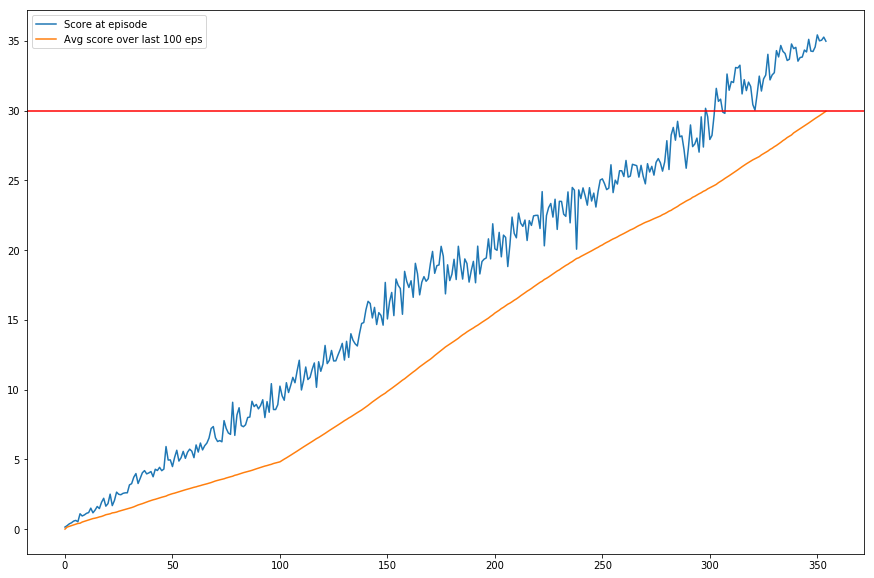

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

plt.plot(all_mean_scores,label='Score at episode')
plt.plot(rolling_average,label='Avg score over last 100 eps')
plt.axhline(y=30,color='r')
plt.legend()
plt.show()

#### 4.5 Simulate the environment with a trained agent

We can try loading the agent and viewing its performance in the environment by setting `train_mode=False`

In [12]:
learned_policy = Policy()
learned_policy.load_state_dict(torch.load('reacher-ppo-policy.PTH'))

In [33]:
env_info = env.reset(train_mode=False)[brain_name]    
states = env_info.vector_observations
for _ in range(200):
    actions, _, _, _ = learned_policy(states)
    env_info = env.step(actions.cpu().detach().numpy())[brain_name]
    next_states = env_info.vector_observations
    states = next_states

c:\users\kvjos\anaconda3\envs\drlnd2\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
